In [1]:
from __future__ import print_function, division

import numpy as np

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot
import scipy.stats as stats
from sympy import symbols

% matplotlib inline

Exercise Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability y that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of y.

How does the spread of the posterior distribution depend on y?

For this problem, we have to define a CoinFlip class that extends Suite. We need to redefine the init method because one of the key parameters is the accuracy of the result measurer. We extend the Suite and add self.y = y. We also have to define a new likelihood method that finds the probability of the data given the hypothesis. First we calculate the probability of heads by dividing the hypothesis by 100. If the flip results in heads, we multiply the probability of heads by the probability that the measurement is correct and add the probability of tails (1-probability of heads) times the probability that the measurement is wrong. If the flip results in tails, we multiply the probability that the measurement is wrong by the probability of heads and add the probability that the measurement is right and multiply it by the probability of tails. For testing, we define the prior as a range of values from 0 to 100 and define three coinflip classes with three different y values. We update all three with data and graph.

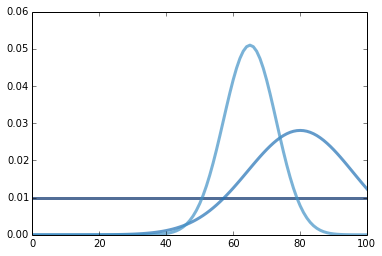

In [2]:
class CoinFlip(Suite):
    
    def __init__(self,prior,y):
        Suite.__init__(self, prior)
        self.y = y
        
    
    def Likelihood(self,data,hypo):
        #hypo is the chance of heads
        #data is the results of measurement, either H or T
        probData = hypo/100
        if data == 'H':
            return probData*self.y+(1-probData)*(1-self.y)
        else:
            return (1-probData)*self.y+probData*(1-self.y)

prior = range(0,101)
coinFlip = CoinFlip(prior,.5)
coinFlip2 = CoinFlip(prior,.6)
coinFlip3 = CoinFlip(prior,.7)
for result in 'H'*140+'T'*110:
    coinFlip.Update(result)
    coinFlip2.Update(result)
    coinFlip3.Update(result)
thinkplot.Pdf(coinFlip)
thinkplot.Pdf(coinFlip2)
thinkplot.Pdf(coinFlip3)

Suppose other evidence had made you 90% confident of Oliver's guilt. How much would this exculpatory evince change your beliefs? What if you initially thought there was only a 10% chance of his guilt?

Notice that evidence with the same strength has a different effect on probability, depending on where you started

First, we define the likeliness of the data given the two hypotheses. After, we define a pmf with the preassumed 90 percent chance that he is guilty. After, we multiply the likelihoods by the p(D) values. Then we normalize and print the results. We can also calculate the probability using odds. First, we convert the probability of Oliver's guilt to odds and use it to calculate the adjusted odds of his guilt. We then convert back to probability and print.

In [3]:
likelinessGuilty = .01 #probability of finding someone with bloodtype AB. 
likelinessNotguilty = 2*.6*.01 #chances of finding someone with bloodtype O multiplied by 
                               #probability of finding bloodtype AB by 2

In [4]:
pmf = Pmf(dict(guilty=.9,notguilty=.1))
pmf['guilty'] *= likelinessGuilty
pmf['notguilty'] *= likelinessNotguilty
pmf.Normalize()
pmf.Print()

guilty 0.882352941176
notguilty 0.117647058824


In [5]:
p = .9
oddsP = p/(1-p)
oddsGuilty = oddsP*(.01/likelinessNotguilty)
probGuilty = oddsGuilty/(oddsGuilty+1)
print(probGuilty)

0.882352941176


Exercise: Suppose I capture and tag 10 rock hyraxes. Some time later, I capture another 10 hyraxes and find that two of them are already tagged. How many hyraxes are there in this environment?

As always with problems like this, we have to make some modeling assumptions.

1) For simplicity, you can assume that the environment is reasonably isolated, so the number of hyraxes does not change between observations.

2) And you can assume that each hyrax is equally likely to be captured during each phase of the experiment, regardless of whether it has been tagged. In reality, it is possible that tagged animals would avoid traps in the future, or possible that the same behavior that got them caught the first time makes them more likely to be caught again. But let's start simple.

I suggest the following notation:

    N: total population of hyraxes
    K: number of hyraxes tagged in the first round
    n: number of hyraxes caught in the second round
    k: number of hyraxes in the second round that had been tagged

So N is the hypothesis and (K, n, k) make up the data. The probability of the data, given the hypothesis, is the probability of finding k tagged hyraxes out of n if (in the population) K out of N are tagged.

If you are familiar with the hypergeometric distribution, you can use the hypergeometric PMF to compute the likelihood function. Otherwise, you can figure it out using combinatorics.


To solve this problem, we need to define a new Hyrax class that extends Suite. For this class, we need to define a new likelihood method. For this method, we take the K, n, and k values as defined above as data and define the N, also explained above, as the hypothesis. If the hypothesis is lower than the total number of tagged hyraxes, then the probability of the hypothesis is zero. Otherwise, the probability can be calculated by taking the hypergeometric distribution found by using the know hypothesis and data. To test, a range of possible hypotheses and the known data is defined. We define a hyrax class using the defined hypos and update it using the data. Finally, we plot the Pdf. 

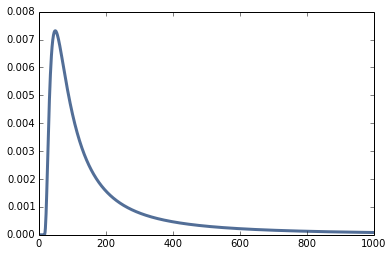

In [6]:
class Hyraxes(Suite):
    
    def Likelihood(self, data, hypo):
        K, n, k = data
        if hypo < K + (n - k):
            return 0
        else:
            return stats.hypergeom.pmf(k, hypo, K, n)
        
hypos = range(1,1000)
data = 10,10,2
hyraxes = Hyraxes(hypos)
hyraxes.Update(data)
thinkplot.Pdf(hyraxes)

Exercise: At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet. Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them. To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

I used a predefined Beta class as shown below to solve this problem. First, I defined a beta class iteration for both Meng and Rhode. I then updated each with the known number of hits and misses. To test, I ran through 100 tests of 25 attempts for each person in each test. I added up all the successes and averaged the number of successes per person. Finally, I printed the results.

In [7]:
from scipy import special

class Beta:
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, label=None):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.label = label if label is not None else '_nolegend_'

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return self.alpha / (self.alpha + self.beta)

    def MAP(self):
        """Computes the value with maximum a posteori probability."""
        a = self.alpha - 1
        b = self.beta - 1
        return a / (a + b)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def Sample(self, n):
        """Generates a random sample from this distribution.

        n: int sample size
        """
        size = n,
        return np.random.beta(self.alpha, self.beta, size)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, label=None):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.

        The result is a little funny, because the values at 0 and 1
        are not symmetric.  Nevertheless, it is a reasonable discrete
        model of the continuous distribution, and behaves well as
        the number of values increases.
        """
        if label is None and self.label is not None:
            label = self.label

        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1) for i in range(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = Pmf(dict(zip(xs, probs)), label=label)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1) for i in range(steps)]
        ps = special.betainc(self.alpha, self.beta, xs)
        cdf = Cdf(xs, ps)
        return cdf

    def Percentile(self, ps):
        """Returns the given percentiles from this distribution.

        ps: scalar, array, or list of [0-100]
        """
        ps = np.asarray(ps) / 100
        xs = special.betaincinv(self.alpha, self.beta, ps)
        return xs


16.573854941
15.7822613711


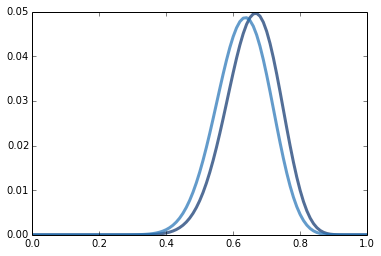

In [8]:
rhode = Beta()
wei = Beta()
rhode.Update((22,11))
wei.Update((21,12))
thinkplot.Pdf(rhode.MakePmf())
thinkplot.Pdf(wei.MakePmf())
rhodeScoreSumTotal = 0
weiScoreSumTotal = 0
for i in range(101):
    rhodeScore = rhode.Sample(25)
    rhodeScoreSum = np.sum(rhodeScore)
    rhodeScoreSumTotal += rhodeScoreSum
    weiScore = wei.Sample(25)
    weiScoreSum = np.sum(weiScore)
    weiScoreSumTotal += weiScoreSum
rhodeTotal = rhodeScoreSumTotal/100
weiTotal = weiScoreSumTotal/100
print(rhodeTotal)
print(weiTotal)

     Alice and Bob are playing a game in which the first person to get 6 points wins. The way each point is decided is a little strange. The Casino has a pool table that Alice and Bob can't see. Before the game begins, the Casino rolls an initial ball onto the table, which comes to rest at a completely random position, which the Casino marks. Then, each point is decided by the Casino rolling another ball onto the table randomly. If it comes to rest to the left of the initial mark, Alice wins the point; to the right of the mark, Bob wins the point. The Casino reveals nothing to Alice and Bob except who won each point. 

    Clearly, the probability that Alice wins a point is the fraction of the table to the left of the mark—call this probability p; and Bob's probability of winning a point is 1 - p. Because the Casino rolled the initial ball to a random position, before any points were decided every value of p was equally probable. The mark is only set once per game, so p is the same for every point. 

    Imagine Alice is already winning 5 points to 3, and now she bets Bob that she's going to win. What are fair betting odds for Alice to offer Bob? That is, what is the expected probability that Alice will win?

I solved this problem by defining a pmf where the chances of Alice or Bob winning are initially zero. I then multiplied by the respective likelihoods. For Alice winning, I multiplied p by 3 choose one because she has to win one more. I cubed Bob's probability of 1-p because he has to win three in a row. I then normalized and printed although I didn't get the right answer because of sympy issues.

In [9]:
p = symbols('p')

In [10]:
pmf = Pmf(dict(aliceWins=1,bobWins=1))
pmf['aliceWins'] *= p*stats.binom(3,1)
pmf['bobWins'] *= (1-p)**3
pmf.Normalize()
pmf.Print()

TypeError: unsupported operand type(s) for *: 'Symbol' and 'rv_frozen'

A professional basketball player in the nba recently made 35 free throws out of the 40 he attempted in a span of ten games. How many free throws will he make if he attempts 6 free throws during his next game?

I defined a beta method iteration called throwSuccess. I then updated it with the number of successes and failures over ten games. I plotted the Pdf that resulted. I also sampled 1000 attempts and averaged the success rate. Finally, I looped through 100 tests of 6 attempts each and averaged the results to find the average number of successes he would have in 6 attempts in one game.

In [ ]:
throwSuccess = Beta()
throwSuccess.Update((35,5))
thinkplot.Pdf(throwSuccess.MakePmf())
throwTest = throwSuccess.Sample(1000)
throwTotal = 0
for i in range(101):
    throwSample = throwSuccess.Sample(6)
    throwSum = np.sum(throwSample)
    throwTotal += throwSum
throwAverage = throwTotal/100
print(throwAverage)
print(np.mean(throwTest))

0.430312998792
0.4


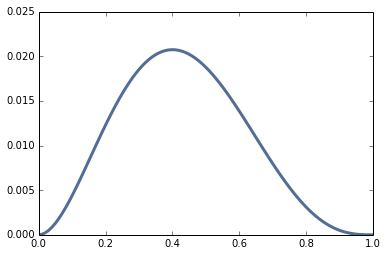

In [12]:
throwSuccess = Beta()
throwSuccess.Update((2,3))
thinkplot.Pdf(throwSuccess.MakePmf())
throwTest = throwSuccess.Sample(1000)
aliens = throwSuccess.MakePmf()
alien = aliens.MaximumLikelihood()
print(np.mean(throwTest))
print(alien)

0.2


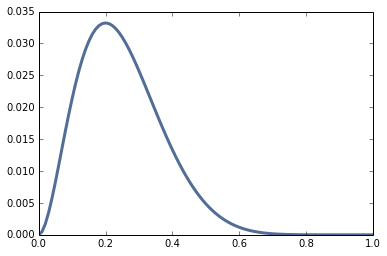

In [13]:
throwSuccess = Beta()
throwSuccess.Update((2,8))
thinkplot.Pdf(throwSuccess.MakePmf())
aliens = throwSuccess.MakePmf()
alien = aliens.MaximumLikelihood()
print(alien)

In [11]:
hypos = xrange(0,101)

class AlienBlaster(Suite):
    
    def Likelihood(self,data,hypo):
        probHit = hypo/100
        numTests,numHits,tie = data
        return (1-probHit)**4+((1-probHit)*(probHit))**2+(probHit)**4
    
alienblaster = AlienBlaster(hypos)
alienblaster.Update(20)
        

0.4390099000000001